In [ ]:
#| echo: false
import logging
import warnings

In [ ]:
#| echo: false
logging.getLogger('statsforecast').setLevel(logging.ERROR)
warnings.simplefilter('ignore')

# Conformal Prediction

> Learn how to generate calibrated prediction intervals for any forecasting model using conformal prediction, a distribution-free method for uncertainty quantification in Python.

## What You'll Learn

In this tutorial, you'll discover how to:

- Generate **calibrated prediction intervals** without distributional assumptions
- Apply conformal prediction to any forecasting model in Python
- Implement uncertainty quantification with StatsForecast's `ConformalIntervals`
- Compare conformal prediction with traditional uncertainty methods
- Evaluate prediction interval coverage and calibration

## Prerequisites

This tutorial assumes basic familiarity with StatsForecast. For a minimal example visit the [Quick Start](../getting-started/1_Getting_Started_short)

## What is Conformal Prediction?

**Conformal prediction** is a distribution-free framework for generating prediction intervals with guaranteed coverage properties. Unlike traditional methods that assume normally distributed errors, conformal prediction works with any forecasting model and provides **well-calibrated uncertainty estimates** without making distributional assumptions.

### Why Use Conformal Prediction for Time Series?

When generating forecasts, a point forecast alone doesn't convey uncertainty. **Prediction intervals** quantify this uncertainty by providing a range of values where future observations are likely to fall. A properly calibrated 95% prediction interval should contain the actual value 95% of the time.

The challenge: many forecasting models either don't provide prediction intervals, or generate intervals that are poorly calibrated. Traditional statistical methods also assume normality, which often doesn't hold in practice.

**Conformal prediction solves this by:**

- Working with any forecasting model (model-agnostic)
- Requiring no distributional assumptions
- Using cross-validation to generate calibrated intervals
- Providing theoretical coverage guarantees
- Treating the forecasting model as a black box

### Conformal Prediction vs. Traditional Methods

| Method | Distributional Assumption | Model-Agnostic | Calibration Guarantee |
|--------|---------------------------|----------------|----------------------|
| **Conformal Prediction** | None | ✓ | ✓ |
| Bootstrap | Parametric assumptions | ✓ | ~ |
| Quantile Regression | None | ✓ | ~ |
| Statistical Models (ARIMA, ETS) | Normal errors | ✗ | ~ |

<Note>For a video introduction, see the [PyData Seattle presentation](https://www.youtube.com/watch?v=Bj1U-Rrxk48). More resources available in [Valery Manokhin's curated list](https://github.com/valeman/awesome-conformal-prediction).</Note>

## Models with Native Prediction Intervals

For models that already provide forecast distributions (like AutoARIMA, AutoETS), check [Prediction Intervals](./UncertaintyIntervals). Conformal prediction is particularly useful for models that only produce point forecasts, or when you want distribution-free intervals.

## How Conformal Prediction Works

Conformal prediction uses **cross-validation** to generate prediction intervals:

1. **Split the training data** into multiple windows
2. **Train the model** on each window and forecast the next period
3. **Calculate residuals** (prediction errors) on the held-out data
4. **Construct intervals** using the distribution of these residuals

The key insight: by studying how the model performs on historical data through cross-validation, we can quantify uncertainty for future predictions without assuming any particular error distribution.

### Real-World Applications

Conformal prediction is particularly valuable for:

- **Demand forecasting**: Inventory planning with quantified uncertainty
- **Energy prediction**: Load forecasting with reliable confidence bounds
- **Financial forecasting**: Risk management with calibrated intervals
- **Production models**: Any black-box forecasting model requiring uncertainty quantification

[StatsForecast](../../index) implements conformal prediction for all available models, making it easy to add calibrated prediction intervals to any forecasting pipeline.

## Install libraries 

We assume that you have StatsForecast already installed. If not, check this guide for instructions on [how to install StatsForecast](../getting-started/0_Installation)

Install the necessary packages using `pip install statsforecast`

In [ ]:
%%capture
pip install statsforecast -U

## Load and explore the data

For this example, we'll use the hourly dataset from the [M4 Competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128). We first need to download the data from a URL and then load it as a `pandas` dataframe. Notice that we'll load the train and the test data separately. We'll also rename the `y` column of the test data as `y_test`.   

In [ ]:
import pandas as pd

In [ ]:
train = pd.read_csv('https://auto-arima-results.s3.amazonaws.com/M4-Hourly.csv')
test = pd.read_csv('https://auto-arima-results.s3.amazonaws.com/M4-Hourly-test.csv').rename(columns={'y': 'y_test'})
train.head()

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0


Since the goal of this notebook is to generate prediction intervals, we'll only use the first 8 series of the dataset to reduce the total computational time. 

In [ ]:
n_series = 8
uids = train['unique_id'].unique()[:n_series] # select first n_series of the dataset
train = train.query('unique_id in @uids')
test = test.query('unique_id in @uids')

We can plot these series using the `plot_series` function from the utilsforecast library. Thisfunctionmethod has multiple parameters, and the required ones to generate the plots in this notebook are explained below. 

- `df`: A `pandas` dataframe with columns [`unique_id`, `ds`, `y`]. 
- `forecasts_df`: A `pandas` dataframe with columns [`unique_id`, `ds`] and models. 
- `plot_random`: bool = `True`. Plots the time series randomly. 
- `models`: List[str]. A list with the models we want to plot. 
- `level`: List[float]. A list with the prediction intervals we want to plot. 
- `engine`: str = `matplotlib`. It can also be `plotly`. `plotly` generates interactive plots, while `matplotlib` generates static plots. 

In [ ]:
from utilsforecast.plotting import plot_series

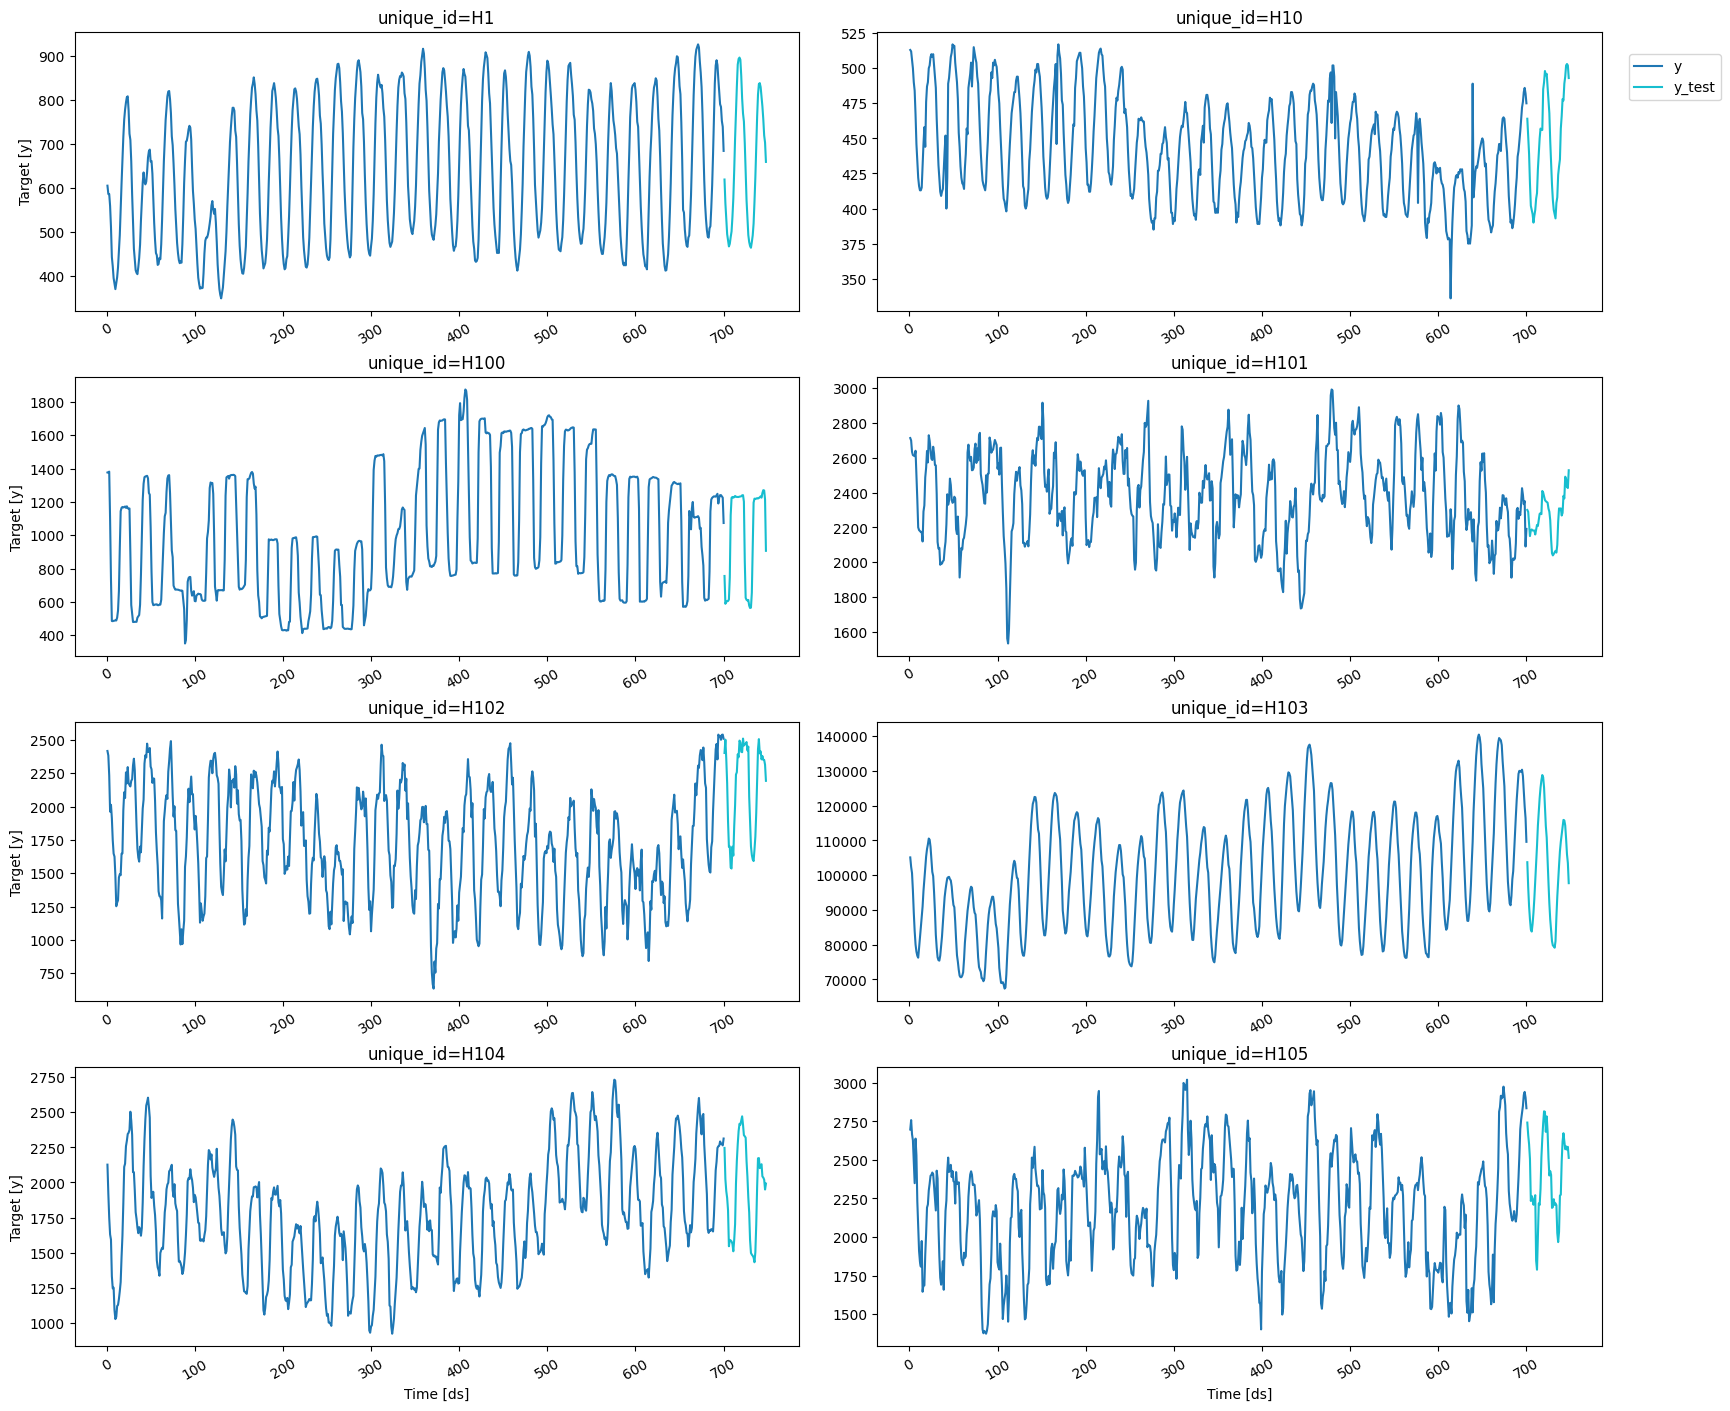

In [ ]:
plot_series(train, test, plot_random=False)

## Implementing Conformal Prediction in Python

StatsForecast makes it simple to add conformal prediction to any forecasting model. We'll demonstrate with models that don't natively provide prediction intervals:

- **[SeasonalExponentialSmoothing](../models/SimpleExponentialSmoothing)**: A simple smoothing model
- **[ADIDA](../models/ADIDA)**: Aggregation method for intermittent demand
- **[ARIMA](../models/ARIMA)**: Traditional statistical model (to show distribution-free intervals)

### Setting Up Conformal Intervals

The key is the `ConformalIntervals` class, which requires two parameters:

- `h`: Forecast horizon (how many steps ahead to predict)
- `n_windows`: Number of cross-validation windows for calibration

### Parameter Requirements

- `n_windows * h` must be less than your time series length
- `n_windows` should be at least 2 for reliable calibration
- Larger `n_windows` improves calibration but increases computation time

In [ ]:
from statsforecast.models import SeasonalExponentialSmoothing, ADIDA, ARIMA
from statsforecast.utils import ConformalIntervals

# Create a list of models and instantiation parameters
intervals = ConformalIntervals(h=24, n_windows=2)
# P.S. n_windows*h should be less than the count of data elements in your time series sequence.
# P.S. Also value of n_windows should be atleast 2 or more.

models = [
    SeasonalExponentialSmoothing(season_length=24, alpha=0.1, prediction_intervals=intervals),
    ADIDA(prediction_intervals=intervals),
    ARIMA(order=(24,0,12), prediction_intervals=intervals),
]

To instantiate a new StatsForecast object, we need the following parameters: 

- `df`: The dataframe with the training data. 
- `models`: The list of models defined in the previous step.  
- `freq`: A string indicating the frequency of the data. See [pandas' available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).
- `n_jobs`: An integer that indicates the number of jobs used in parallel processing. Use -1 to select all cores. 

In [ ]:
sf = StatsForecast(models=models, freq=1, n_jobs=-1)

## Generating Forecasts with Prediction Intervals

The `forecast` method generates both point forecasts and conformal prediction intervals:

- `h`: Forecast horizon (number of steps ahead)
- `level`: List of confidence levels (e.g., `[80, 90]` for 80% and 90% intervals)

The output includes columns for each model's forecast and corresponding prediction interval bounds (`model-lo-{level}`, `model-hi-{level}`).

In [ ]:
levels = [80, 90] # confidence levels of the prediction intervals

forecasts = sf.forecast(df=train, h=24, level=levels)
forecasts.head()

,unique_id,ds,SeasonalES,SeasonalES-lo-90,SeasonalES-lo-80,SeasonalES-hi-80,SeasonalES-hi-90,ADIDA,ADIDA-lo-90,ADIDA-lo-80,ADIDA-hi-80,ADIDA-hi-90,ARIMA,ARIMA-lo-90,ARIMA-lo-80,ARIMA-hi-80,ARIMA-hi-90
0,H1,701,624.132703,553.097423,556.359139,691.906266,695.167983,747.292568,599.519220,600.030467,894.554670,895.065916,618.078274,609.440076,610.583304,625.573243,626.716472
1,H1,702,555.698193,496.653559,506.833156,604.563231,614.742827,747.292568,491.669220,498.330467,996.254670,1002.915916,549.789291,510.464070,515.232352,584.346231,589.114513
2,H1,703,514.403029,462.673117,464.939840,563.866218,566.132941,747.292568,475.105038,475.793791,1018.791346,1019.480099,508.099925,496.574844,496.990264,519.209587,519.625007
3,H1,704,482.057899,433.030711,436.161413,527.954385,531.085087,747.292568,440.069220,440.130467,1054.454670,1054.515916,486.376622,471.141813,471.516997,501.236246,501.611431
4,H1,705,460.222522,414.270186,416.959492,503.485552,506.174858,747.292568,415.805038,416.193791,1078.391346,1078.780099,470.159478,445.162316,446.808608,493.510348,495.156640


## Visualizing Calibrated Prediction Intervals

Let's examine the prediction intervals for each model to understand their characteristics and calibration quality.

### SeasonalExponentialSmoothing: Well-Calibrated Intervals

The conformal prediction intervals show proper nesting: the 80% interval is contained within the 90% interval, indicating well-calibrated uncertainty quantification. Even though this model only produces point forecasts, conformal prediction successfully generates meaningful prediction intervals.

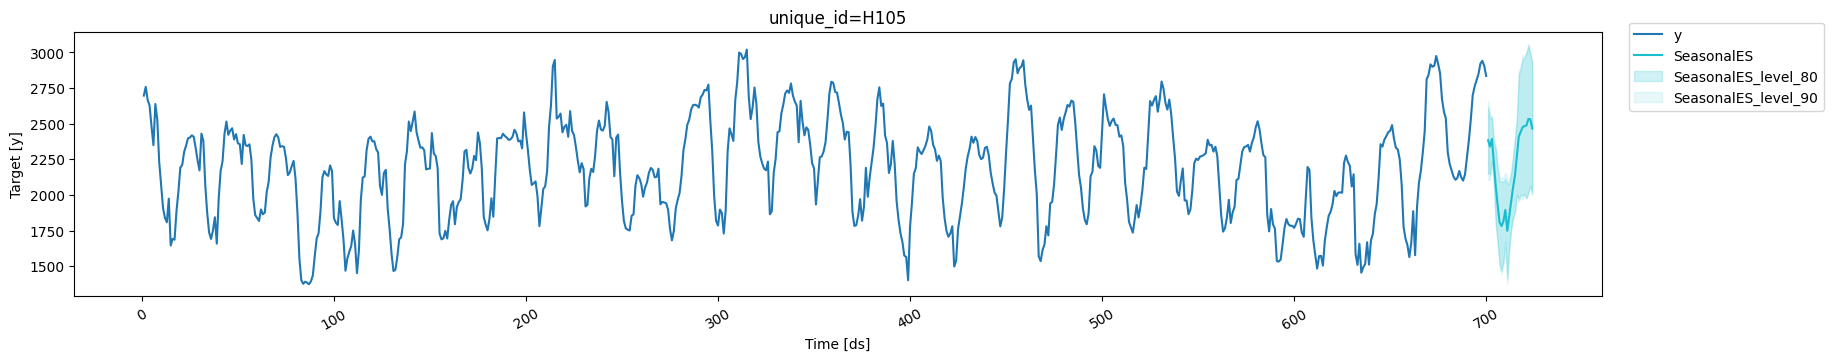

In [ ]:
plot_series(train, forecasts, level=levels, ids=['H105'], models=['SeasonalES'])

### ADIDA: Wider Intervals for Weaker Models

Models with higher prediction errors produce wider conformal intervals. This is a feature, not a bug: the interval width honestly reflects the model's uncertainty. A better-fitting model will produce narrower, more informative intervals.

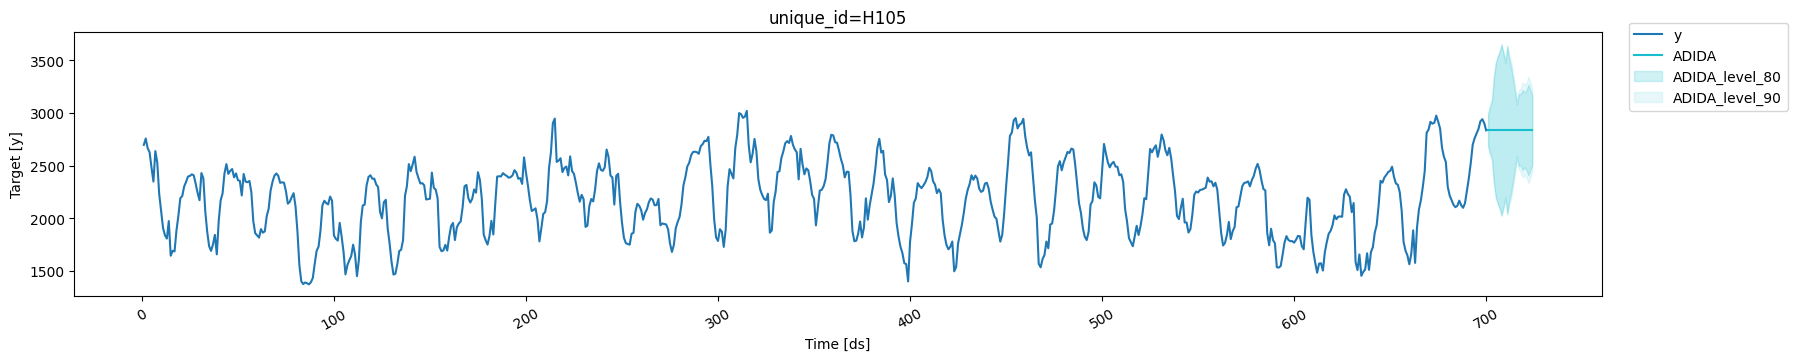

In [ ]:
plot_series(train, forecasts, level=levels, ids=['H105'], models=['ADIDA'])

### ARIMA: Distribution-Free Alternative

ARIMA models typically provide prediction intervals assuming normally distributed errors. By using conformal prediction, we get distribution-free intervals that don't rely on this assumption, which is valuable when the normality assumption is questionable.

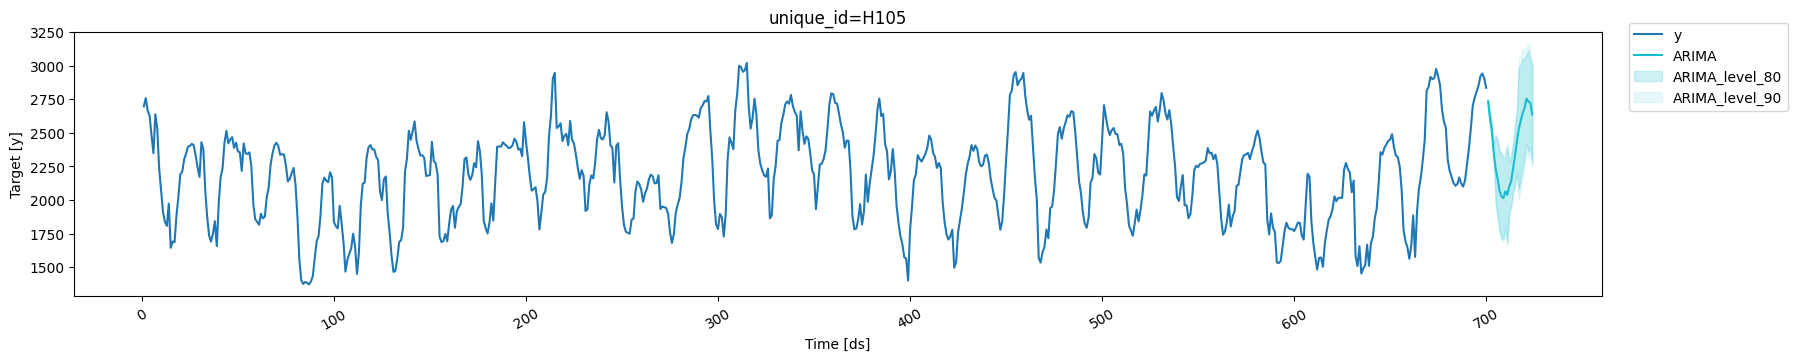

In [ ]:
plot_series(train, forecasts, level=levels, ids=['H105'], models=['ARIMA'])

## Alternative: Setting Conformal Intervals on StatsForecast Object

You can apply conformal prediction to all models at once by specifying `prediction_intervals` in the `StatsForecast` object. This is convenient when you want the same conformal setup for multiple models.

In [ ]:
from statsforecast.models import SimpleExponentialSmoothing, ADIDA
from statsforecast.utils import ConformalIntervals
from statsforecast import StatsForecast

models = [
    SimpleExponentialSmoothing(alpha=0.1),
    ADIDA()
]

res = StatsForecast(
    models=models,
    freq=1,
).forecast(df=train, h=24, prediction_intervals=ConformalIntervals(h=24, n_windows=2), level=[80])
res.head()

,unique_id,ds,SES,SES-lo-80,SES-hi-80,ADIDA,ADIDA-lo-80,ADIDA-hi-80
0,H1,701,742.669064,649.221405,836.116722,747.292568,600.030467,894.554670
1,H1,702,742.669064,550.551324,934.786804,747.292568,498.330467,996.254670
2,H1,703,742.669064,523.621405,961.716722,747.292568,475.793791,1018.791346
3,H1,704,742.669064,488.121405,997.216722,747.292568,440.130467,1054.454670
4,H1,705,742.669064,464.021405,1021.316722,747.292568,416.193791,1078.391346


## Future work

Conformal prediction has become a powerful framework for uncertainty quantification, providing well-calibrated prediction intervals without making any distributional assumptions. Its use has surged in both academia and industry over the past few years. We'll continue working on it, and future tutorials may include:

- Exploring larger datasets
- Incorporating industry-specific examples
- Investigating specialized methods like the jackknife+ that are closely related to conformal prediction (for details on the jackknife+ see [here](https://valeman.medium.com/jackknife-a-swiss-knife-of-conformal-prediction-for-regression-ce3b56432f4f))

If you're interested in any of these, or in any other related topic, please let us know by opening an issue on [GitHub](https://github.com/Nixtla/statsforecast/issues)

## Key Takeaways

### Summary: Conformal Prediction for Time Series

- **Model-agnostic**: Works with any forecasting model in Python  
- **Distribution-free**: No normality assumptions required  
- **Well-calibrated**: Theoretical coverage guarantees  
- **Easy to implement**: Just add `ConformalIntervals` to your StatsForecast models  
- **Flexible**: Apply to individual models or all models at once

**Next steps:**

- Try conformal prediction on your own forecasting problems
- Experiment with different `n_windows` values for optimal calibration
- Compare with native prediction intervals from statistical models
- Explore [advanced uncertainty quantification methods](./UncertaintyIntervals)

## Acknowledgements

We would like to thank [Kevin Kho](https://github.com/kvnkho) for writing this tutorial, and Valeriy [Manokhin](https://github.com/valeman) for his expertise on conformal prediction, as well as for promoting this work.

## References

[Manokhin, Valery. (2022). Machine Learning for Probabilistic Prediction. 10.5281/zenodo.6727505. ](https://zenodo.org/record/6727505)